In [18]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from ctapipe.io import event_source
import sys
 
from matplotlib import pyplot as plt
import numpy as np
import sys
from scipy.stats import norm
from traitlets.config.loader import Config 

# ctapipe modules
from ctapipe import utils
from ctapipe.visualization import CameraDisplay
from ctapipe.plotting.camera import CameraPlotter
from ctapipe.image.extractor import *
from ctapipe.io import EventSeeker 

# lstchain modules
from lstchain.calib.camera.r0 import LSTR0Corrections

r0calib = LSTR0Corrections(
    pedestal_path="/astro/users/cassol/soft/python/lstchain-test/pedestal_run97_new.fits",
    r1_sample_start=2,r1_sample_end=38)


from ctapipe.io.containers import PedestalContainer
from ctapipe.io.hdf5tableio import HDF5TableWriter, HDF5TableReader


# a flat field run with interleaved pedestals (for the moment to big for cta-lstchain-extra)
run = 251
file = '/ctadata/franca/LST/LST-1.1.Run00{0}.0000.fits.fz'.format(run)

reader = event_source(file, max_events=1000)

channel=['HG','LG']

tel_id=0 # hopefully it will be 1 for EvB v3

In [19]:
# read first pedestal event

for i, event in enumerate(reader): 
    
    # select only pedestal events    
    if event.r0.tel[0].trigger_type != 32:        
        continue
           
    # calibrate r0 --> r1        
    r0calib.calibrate(event)
    
    break
        
print(f"read event id: {event.r0.event_id}, trigger {event.r0.tel[0].trigger_type}")


read event id: 14, trigger 32


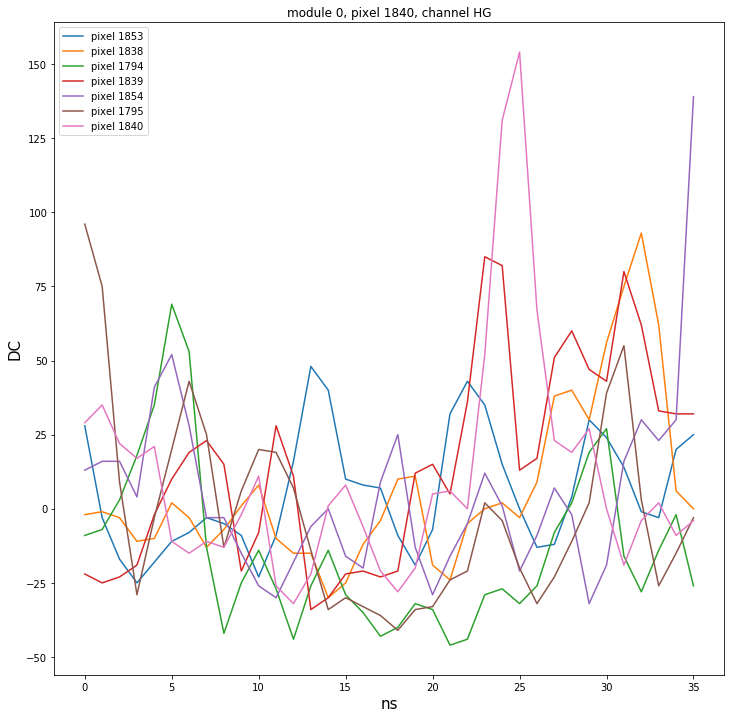

In [23]:
# plot R1 waveform of module [module]
def view_waveform(chan=0, pix_id=6,i=0):
    waveform = event.r1.tel[tel_id].waveform
    plt.plot(waveform[chan, pix_id], label=f'pixel {pix_id}')
  
    plt.title(f"module {module}, pixel {pix_id}, channel {channel[chan]}",)
    max_now=waveform[chan, pix_id].max()
    min_now=waveform[chan, pix_id].min()


    plt.legend()
    plt.ylabel('DC',fontsize=15) 
    plt.xlabel('ns',fontsize=15)
    

# module number    
module=0
# channel
chan=0
# ids of pixel in module
pixels_mod=event.lst.tel[0].svc.pixel_ids[module*7:module*7+7]
 
fig = plt.figure(num=0,figsize=(12,12))     

for i,pix  in enumerate(pixels_mod):    

    view_waveform(chan=chan, pix_id=pix,i=i)
    
#plt.savefig(f"Run{run}_low_level_correction_{channel[chan]}_mod{modu}.png")    

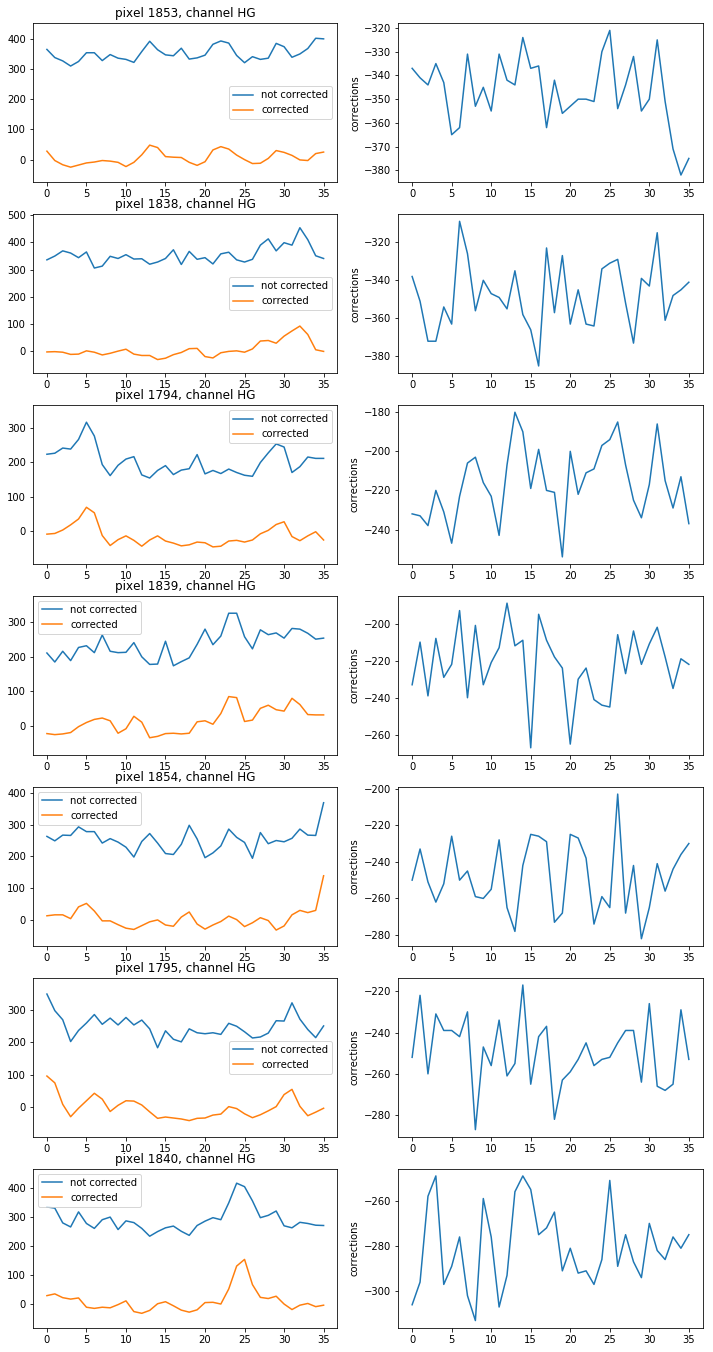

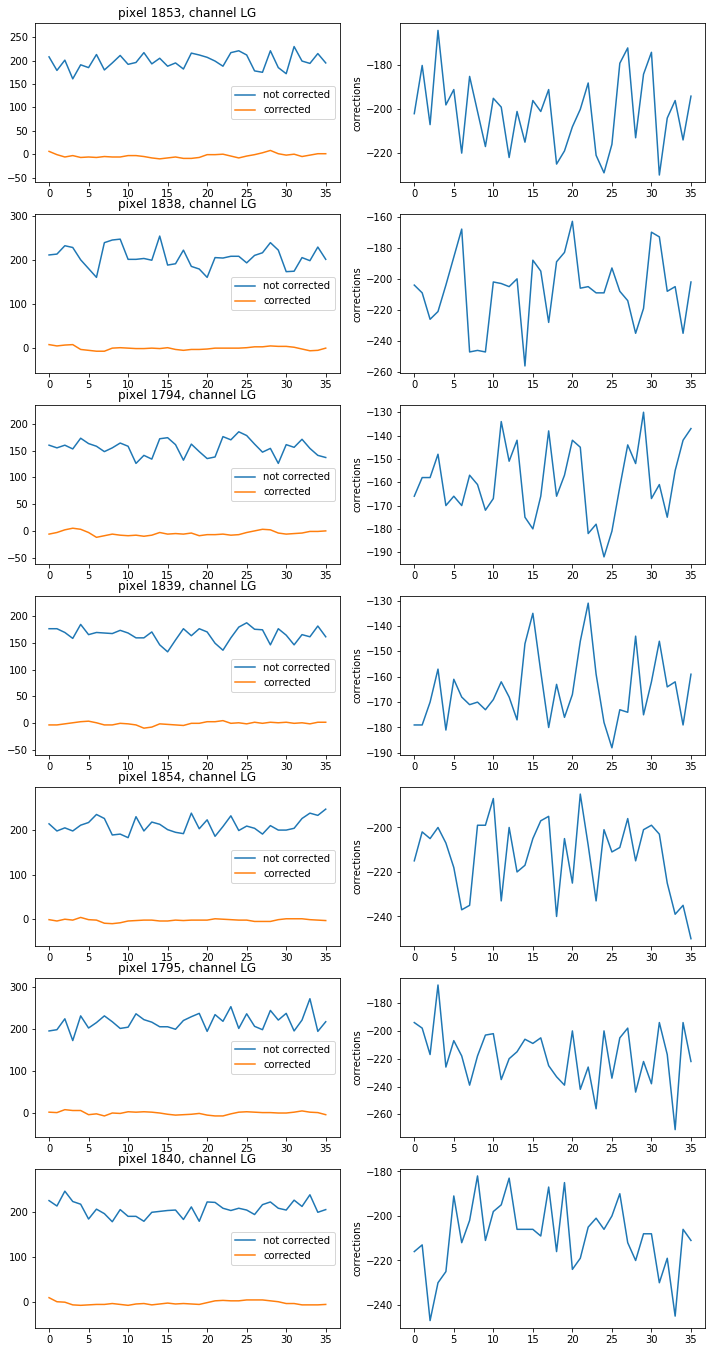

In [13]:
# plot effect of low-level calibration on module 
def view_waveform(chan=0, pix_id=6,i=0):

    plot_id=i*2+1
    plt.subplot(7,2,plot_id)
 
    plt.plot(event.r0.tel[tel_id].waveform[chan, pix_id,2:38], label='not corrected')
    plt.plot(event.r1.tel[tel_id].waveform[chan, pix_id], label='corrected') 
    
    plt.title(f"pixel {pix_id}, channel {channel[chan]}",)
    
    mymax=max(newwaveform[chan, pix_id].max(),oldwaveform[chan, pix_id].max()) + 50
    mymin=min(newwaveform[chan, pix_id].min(),oldwaveform[chan, pix_id].min()) - 50
    
    plt.ylim(mymin,mymax)
    plt.legend()
    plot_id=(i*2)+2
    
    plt.subplot(7,2,plot_id)
    plt.plot(newwaveform[chan, pix_id]-oldwaveform[chan, pix_id])
    plt.ylabel('corrections',fontsize=10) 
    
# module number    
module=0

# ids of pixel in module
pixels_mod=event.lst.tel[0].svc.pixel_ids[module*7:module*7+7]
 # r0
newwaveform = event.r1.tel[tel_id].waveform
# R1
oldwaveform = event.r0.tel[tel_id].waveform[:,:,2:38]

for i,pix  in enumerate(pixels_mod):
    
    for chan in(np.arange(2)): 
        
        plt.figure(num=chan,figsize=(12,24)) 
        # plot waveform of selected channel
        view_waveform(chan=chan, pix_id=pix,i=i)
    
#plt.savefig(f"Run{run}_low_level_correction_{channel[chan]}_mod{modu}.png")    

channel HG: mean -49.3498649597168 +- 218.2276153564453
channel LG: mean -39.768733978271484 +- 37.303340911865234


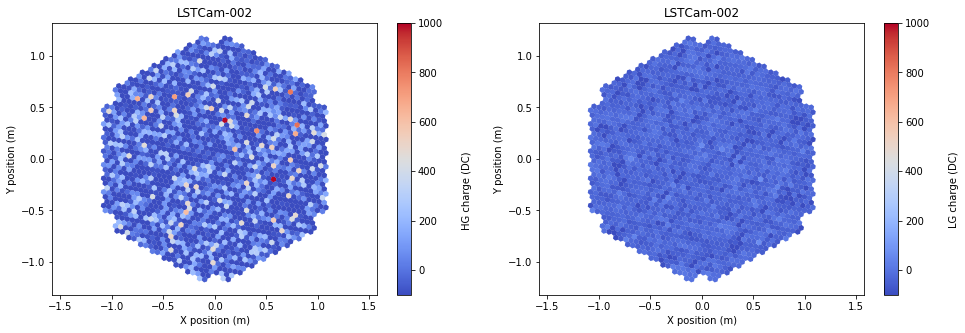

In [24]:
# integrate the charge of pedestal waveform and plot the camera charges

config = Config({
    "FixedWindowSum": {
        "window_start": 12,
        "window_width": 12 
    }
})
integrator = FixedWindowSum(config=config)

waveform=event.r1.tel[0].waveform
image, peakpos = integrator(waveform)

fig = plt.figure(figsize=(16, 5))

chan =0
ax = plt.subplot(1, 2, 1)
disp = CameraDisplay(event.inst.subarray.tels[0].camera)
disp.image = image[chan]  
disp.cmap = plt.cm.coolwarm
disp.set_limits_minmax(-100,1000)
disp.axes.text(2.4, 0, f'{channel[chan]} charge (DC)', rotation=90)
disp.add_colorbar()
print(f"channel {channel[chan]}: mean {image[chan].mean()} +- {image[chan].std()}")

ax = plt.subplot(1, 2, 2)
chan =1
disp = CameraDisplay(event.inst.subarray.tels[0].camera)
disp.image = image[chan]  
disp.set_limits_minmax(-100,1000)
disp.cmap = plt.cm.coolwarm
disp.axes.text(2.4, 0, f'{channel[chan]} charge (DC)', rotation=90)

disp.add_colorbar()
print(f"channel {channel[chan]}: mean {image[chan].mean()} +- {image[chan].std()}")

#plt.savefig(f"Run{run}_event_{event.lst.tel[0].evt.event_id}.png")   

get container after at event 978 after 241 events
[0, 1]


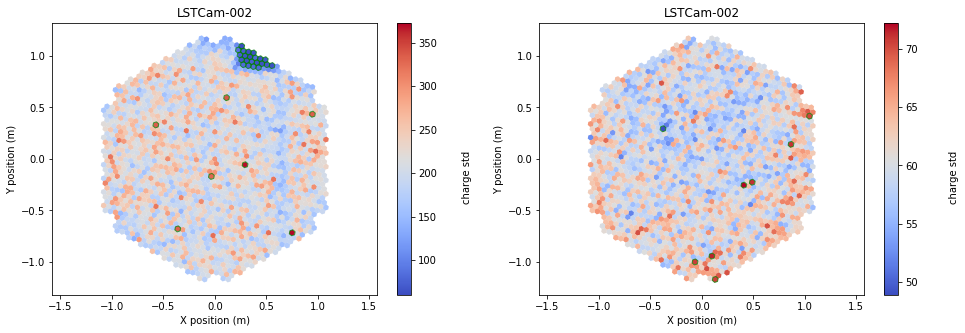

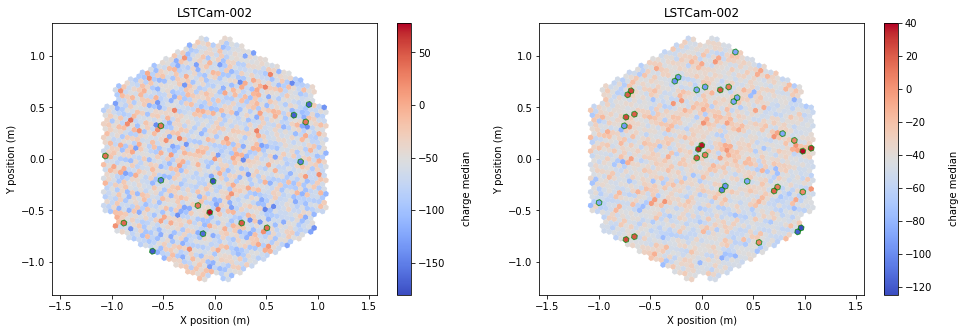

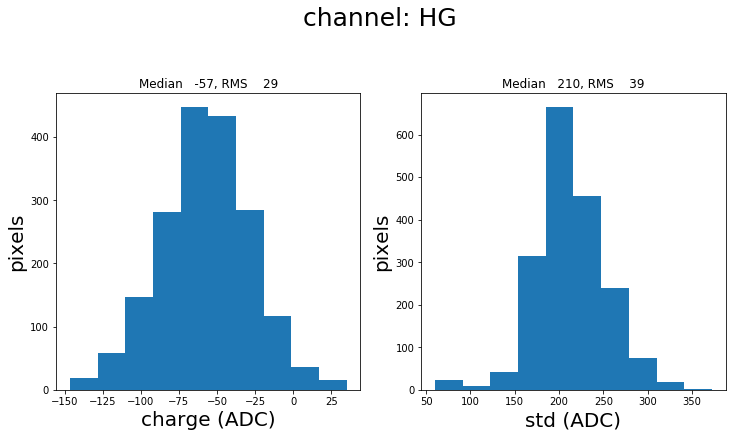

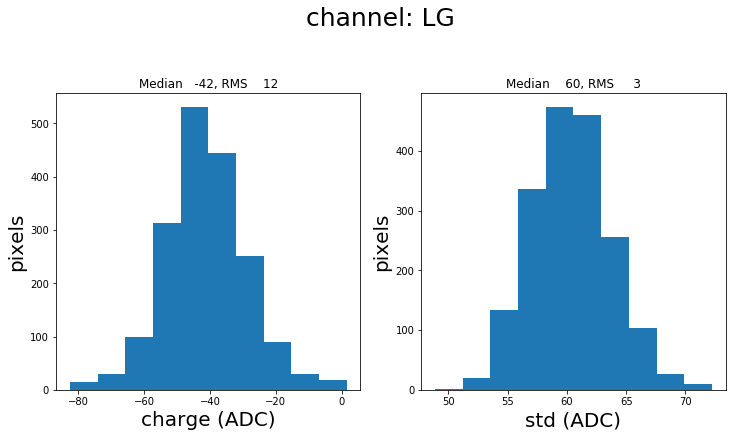

In [25]:
# fill pedestal container and write it on disk
from lstchain.tools.calc_pedestals import PedestalHDF5Writer
from ctapipe.calib.camera.pedestals import PedestalIntegrator

# declare a writer
filename= f"pedestal_run{run}.hdf5"
tel_id = 0

# configuration for the charge integrator
charge_config = Config({
    "FixedWindowSum": {
        "window_start": 12,
        "window_width": 12,
    }
    
})
    
# declare the pedestal component
pedestal = PedestalIntegrator(tel_id=tel_id,
                                    sample_size = 100,
                                    sample_duration = 10000,  
                                    charge_median_cut_outliers = [-3,3],
                                    charge_std_cut_outliers = [-3,3],
                                    charge_product="FixedWindowSum",
                                    config=charge_config)




for i, event in enumerate(reader):


    # select only pedestal events    
    if event.r0.tel[tel_id].trigger_type != 32:        
        continue
        
    # move from R0 to R1
    r0calib.calibrate(event)

     
    
    if pedestal.calculate_pedestals(event):
        ped_data = event.mon.tel[tel_id].pedestal
       
        print(f"get container after at event {event.r0.event_id} after {i+1} events")
        # stop after first event
        break
        
# plot data
fig = plt.figure(10,figsize=(16, 5))
        

image = ped_data.charge_std
mask=  ped_data.charge_std_outliers 
chan =0      
ax = plt.subplot(1, 2, 1)
disp = CameraDisplay(event.inst.subarray.tels[0].camera)
disp.highlight_pixels(mask[chan])
disp.image = image[chan]  
disp.cmap = plt.cm.coolwarm
disp.axes.text(2.4, 0, 'charge std', rotation=90)
disp.add_colorbar()
lis = []
lis =ped_data.charge_std_outliers
res = [i for i, val in enumerate(lis) if True]
print(res)
ax = plt.subplot(1, 2, 2)
chan=1
disp = CameraDisplay(event.inst.subarray.tels[0].camera)
disp.highlight_pixels(mask[chan])
disp.image = image[chan]  
disp.cmap = plt.cm.coolwarm
disp.add_colorbar()
disp.axes.text(2.4, 0, 'charge std', rotation=90)
fig = plt.figure(11,figsize=(16, 5))
mask=  ped_data.charge_median_outliers 
#
image = ped_data.charge_median
#plt.savefig(f"std_{channel[chan]}.png")
chan =0
        
ax = plt.subplot(1, 2, 1)
disp = CameraDisplay(event.inst.subarray.tels[0].camera)
disp.highlight_pixels(mask[chan])
disp.image = image[chan]  
disp.cmap = plt.cm.coolwarm
disp.add_colorbar()
disp.axes.text(2.4, 0, 'charge median', rotation=90)
ax = plt.subplot(1, 2, 2)
chan =1
        
disp = CameraDisplay(event.inst.subarray.tels[0].camera)
disp.highlight_pixels(mask[chan])
disp.image = image[chan]  
disp.cmap = plt.cm.coolwarm
disp.axes.text(2.4, 0, 'charge median', rotation=90)
disp.add_colorbar()   
#plt.savefig(f"pedestal_median_r1.png")        
for chan in np.arange(2):
            
    fig = plt.figure(chan,figsize=(12,12))
    median_charge=ped_data.charge_median[chan]
    std_charge=ped_data.charge_std[chan]
    mean_charge=ped_data.charge_mean[chan]
    median_charge=ped_data.charge_median[chan]
            
    select = np.logical_not(mask[chan])

    fig.suptitle(f"channel: {channel[chan]}", fontsize=25) 
    plt.subplot(221)
    median= np.median(median_charge[select]) 
    rms= np.std(median_charge[select])
    plt.title(f"Median {median:5.0f}, RMS {rms:5.0f}") 
    plt.xlabel('charge (ADC)',fontsize=20)
    plt.ylabel('pixels',fontsize=20)  
           
    plt.hist(median_charge[select])  
    plt.subplot(222)
    plt.ylabel('pixels',fontsize=20) 
    plt.xlabel('std (ADC)',fontsize=20)
    
    plt.hist(std_charge[select])
    median= np.median(std_charge[select]) 
    rms= np.std(std_charge[select])
    plt.title(f"Median {median:5.0f}, RMS {rms:5.0f}") 
   
 
    #plt.savefig(f"pedestal_{channel[chan]}.png")
    
      

In [27]:
# use the tool to write flat fields (still with partial waveform treatement)
from lstchain.tools.calc_pedestals import PedestalHDF5Writer
pedestal_tool= PedestalHDF5Writer()
#pedestal_tool.print_help()

In [28]:
# 
pedestal_tool.run(argv=['--config','/astro/users/cassol/soft/python/cta-lstchain/lstchain/tools/pedestal_param.json'])

INFO [PedestalHDF5Writer] (tool/initialize): ctapipe version 0.6.2.post158+gite4030e3
INFO [PedestalHDF5Writer] (tool/run): Starting: PedestalHDF5Writer
INFO [PedestalHDF5Writer.PedestalIntegrator] (pedestals/__init__): extractor <ctapipe.image.extractor.FixedWindowSum object at 0x7fb73d7a8b70>
INFO [PedestalHDF5Writer.PedestalIntegrator] (pedestals/__init__): Used events statistics : 100
INFO [PedestalHDF5Writer] (tool/run): CONFIG: {'PedestalHDF5Writer': {'calculator_product': 'PedestalIntegrator', 'config_file': '/astro/users/cassol/soft/python/cta-lstchain/lstchain/tools/pedestal_param.json', 'log_datefmt': '%Y-%m-%d %H:%M:%S', 'log_format': '%(levelname)s [%(name)s] (%(module)s/%(funcName)s): %(message)s', 'log_level': 10, 'output_file': '/astro/users/cassol/soft/python/lstchain-test/pedestal.hdf5', 'r0calibrator_product': 'LSTR0Corrections'}}
DEBUG [PedestalHDF5Writer] (calc_pedestals/start):  r0 (2, 1855, 40)
DEBUG [PedestalHDF5Writer] (calc_pedestals/start):  r1 (2, 1855, 36)
D

(array([  79,  122,  440,  502,  570,  604,  877,  894,  921, 1012, 1254,
       1558, 1576, 1677, 1723]),)
(array([  51,  121,  532,  554,  656,  872, 1393, 1394, 1395, 1396, 1520,
       1521, 1522, 1523, 1524, 1525, 1526, 1633, 1634, 1635, 1636, 1637,
       1638, 1702, 1721, 1729, 1730, 1731, 1732, 1801]),)
1
(array([  79,  440,  500,  583, 1033, 1167, 1254]),)
(array([ 656,  862, 1383, 1391, 1393, 1394, 1396, 1507, 1520, 1521, 1522,
       1523, 1524, 1525, 1526, 1625, 1633, 1634, 1635, 1636, 1637, 1638,
       1729, 1730, 1731, 1732, 1801]),)
2


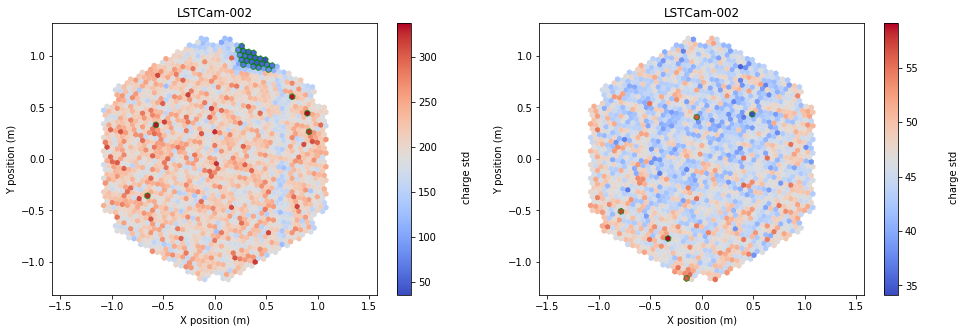

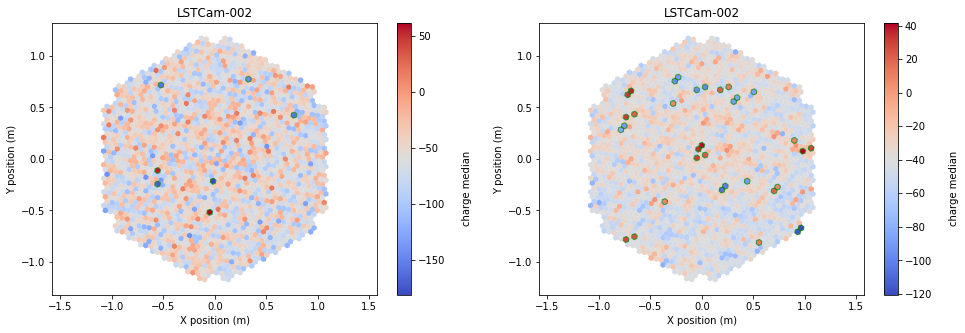

In [29]:

# read back pedestalContainer container writen with the tool calc_pedestal.py
from ctapipe.io.containers import PedestalContainer
from ctapipe.io.hdf5tableio import HDF5TableWriter, HDF5TableReader

ped_data = PedestalContainer()

#with HDF5TableReader('/astro/users/cassol/soft/python/cta-lstchain/lstchain/tools/pedestal.hdf5') as h5_table:
with HDF5TableReader('/astro/users/cassol/soft/python/lstchain-test/pedestal.hdf5') as h5_table:
    
    assert h5_table._h5file.isopen == True

    count = 0
    ped_charge = [] 
    ped_std = []
    for ped_data in h5_table.read('/tel_0/pedestal', ped_data):
        count+=1
        ped_charge.append([np.median(ped_data.charge_median, axis=1)])
        ped_std.append([np.median(ped_data.charge_std, axis=1)])
        print(np.where(ped_data.charge_median_outliers[0]==True))
        print(np.where(ped_data.charge_std_outliers[0]==True))
        
        print(count)
        #break 
        
fig = plt.figure(300,figsize=(16, 5))

chan =0
image = ped_data.charge_std
mask=  ped_data.charge_std_outliers 

ax = plt.subplot(1, 2, 1)
disp = CameraDisplay(event.inst.subarray.tels[0].camera)
disp.highlight_pixels(mask[chan])
disp.image = image[chan]  
disp.cmap = plt.cm.coolwarm
disp.axes.text(2.4, 0, 'charge std', rotation=90)
disp.add_colorbar()

ax = plt.subplot(1, 2, 2)
chan=1
disp = CameraDisplay(event.inst.subarray.tels[0].camera)
disp.highlight_pixels(mask[chan])
disp.image = image[chan]  
disp.cmap = plt.cm.coolwarm
disp.add_colorbar()
disp.axes.text(2.4, 0, 'charge std', rotation=90)

fig = plt.figure(11,figsize=(16, 5))
mask=  ped_data.charge_median_outliers 
image = ped_data.charge_median
chan =0

ax = plt.subplot(1, 2, 1)
disp = CameraDisplay(event.inst.subarray.tels[0].camera)
disp.highlight_pixels(mask[chan])
disp.image = image[chan]  
disp.cmap = plt.cm.coolwarm
disp.add_colorbar()
disp.axes.text(2.4, 0, 'charge median', rotation=90)
ax = plt.subplot(1, 2, 2)
chan =1

disp = CameraDisplay(event.inst.subarray.tels[0].camera)
disp.highlight_pixels(mask[chan])
disp.image = image[chan]  
disp.cmap = plt.cm.coolwarm
disp.axes.text(2.4, 0, 'charge median', rotation=90)
disp.add_colorbar()   

